# Daten kombinieren

**Inhalt:** Verschiedene Quellen kombinieren, optisch und tabellarisch auswerten

**Nötige Skills:** Daten explorieren, filtern, klassifizieren

**Lernziele:**
- Besser verstehen, wie Merge funktioniert
- Daten kombinieren, Kategorien bilden und auswerten
- Daten exportieren und in anderem Programm visualisieren

# Das Beispiel

Nationalratswahlen. Wir analysieren die Veränderung über die letzten 20 Jahre:
1. über alle Gemeinden hinweg
2. für bestimmte Gruppen von Gemeinden (zB je nach Sprachregion)
3. zum Schluss stellen wir die Ergebnisse in Karten dar

Angelehnt an: https://www.republik.ch/2019/10/21/gruener-jurabogen-und-gruenliberales-zuerich

**Quellen:**
- Wahlergebnisse beim BFS: Daten gibts beim BFS: https://www.pxweb.bfs.admin.ch/pxweb/de/px-x-1702020000_105/px-x-1702020000_105/px-x-1702020000_105.px
- Diverse Daten zu Gemeinden, zusammengetragen beim BFS



## Vorbereitung

Wir importieren ausnahmsweise etwas mehr Bibliotheken als sonst...

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import geopandas as gpd

## Daten laden

**Wahlergebnisse**

Wir haben uns schonmal ein hübsches geputztes File vorbereitet.

Das ist unser Hauptfile - es enthält die Wähleranteile der Parteien in den Jahren 1999 und 2019.

In [4]:
path = 'dataprojects/wahlen/Wahlergebnisse 1999 und 2019 in Gemeinden.csv'

In [5]:
df = pd.read_csv(path)

In [6]:
df

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019
0,1,Aeugst am Albis,BDP,NaN,1.26
1,1,Aeugst am Albis,CSP,0.09,NaN
2,1,Aeugst am Albis,CVP,2.59,2.50
3,1,Aeugst am Albis,EDU,3.21,3.43
4,1,Aeugst am Albis,EVP,1.44,3.23
...,...,...,...,...,...
26842,9250,GE-CH de l'étranger,SP,21.28,14.55
26843,9250,GE-CH de l'étranger,SVP,5.41,13.49
26844,9250,GE-CH de l'étranger,Übrige,3.04,1.33
26845,9250,GE-CH de l'étranger,Sol.,7.58,6.58


**Gemeindetypologie**

Wir haben eine Hilfsdatei - sie enthält für jede Gemeinde ein paar Zusatzinformationen:
- Welchem Raumtyp sie zugehört
- In welcher Grossregion sie liegt
- Welche Sprache gesprochen wird
- Der Ausländeranteil
- Wie stark die Bevölkerugungszahl gewachsen ist

In [7]:
df_typen = pd.read_excel('dataprojects/wahlen/Gemeindetypologie.xlsx')

In [8]:
df_typen

,Gemeinde_ID,Raumtyp,Grossregion,Sprache,Ausländeranteil,Bevölkerungswachstum_2010-17
0,1,3: Ländlich,4: Zürich,1: Deutsch,12.725399,6.414474
1,2,1: Städtisch,4: Zürich,1: Deutsch,28.593776,9.512217
2,3,2: Intermediär,4: Zürich,1: Deutsch,15.475327,6.842411
3,4,2: Intermediär,4: Zürich,1: Deutsch,15.147380,9.047619
4,5,1: Städtisch,4: Zürich,1: Deutsch,15.240931,8.328446
...,...,...,...,...,...,...
2207,6806,3: Ländlich,2: Espace Mittelland,2: Französisch,9.335727,1.457195
2208,6807,3: Ländlich,2: Espace Mittelland,2: Französisch,7.508251,-7.268554
2209,6808,3: Ländlich,2: Espace Mittelland,2: Französisch,8.135073,3.330690
2210,6809,3: Ländlich,2: Espace Mittelland,2: Französisch,8.423913,-4.415584


Unser Ziel ist, die Informationen aus dieser Tabelle mit den Wähleranteilen zu verbinden, so dass wir gruppierte Auswertungen machen können.

## Vorbereitung

Zuerst müssen wir uns die Daten nochmals ganz genau anschauen.

In [9]:
df.head(20)

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019
0,1,Aeugst am Albis,BDP,NaN,1.26
1,1,Aeugst am Albis,CSP,0.09,NaN
2,1,Aeugst am Albis,CVP,2.59,2.50
3,1,Aeugst am Albis,EDU,3.21,3.43
4,1,Aeugst am Albis,EVP,1.44,3.23
5,1,Aeugst am Albis,FDP,24.67,16.42
6,1,Aeugst am Albis,FGA,1.51,0.30
7,1,Aeugst am Albis,FPS,0.08,NaN
8,1,Aeugst am Albis,GLP,NaN,14.32
9,1,Aeugst am Albis,GPS,4.11,15.05


**NA-Values**

Wir müssen uns überlegen: Was heissen leere Zeilen (NaN) genau?

- Wir könnten sagen: Diese Einträge wollen wir gar nicht anschauen...
- ... oder wir könnten sagen: Wähleranteil der betreffenden Partei = 0

Pandas bietet eine praktische Funktion, um NaN zu ersetzen: `fillna()`

In [10]:
df['2019'] = df['2019'].fillna(0)
df['1999'] = df['1999'].fillna(0)

In [11]:
df.head(20)

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019
0,1,Aeugst am Albis,BDP,0.00,1.26
1,1,Aeugst am Albis,CSP,0.09,0.00
2,1,Aeugst am Albis,CVP,2.59,2.50
3,1,Aeugst am Albis,EDU,3.21,3.43
4,1,Aeugst am Albis,EVP,1.44,3.23
5,1,Aeugst am Albis,FDP,24.67,16.42
6,1,Aeugst am Albis,FGA,1.51,0.30
7,1,Aeugst am Albis,FPS,0.08,0.00
8,1,Aeugst am Albis,GLP,0.00,14.32
9,1,Aeugst am Albis,GPS,4.11,15.05


**Veränderung**

Als nächstes überlegen wir uns, was uns eigentlich interessiert.

Wir kennen bereits für jede Partei und Gemeinde:
- den Wähleranteil 1999
- den Wähleranteil 2019

Was wir noch berechnen müssen:
- die Veränderung von 1999 bis 2019

Hier ist ein guter Ort, um das zu tun.

In [12]:
df['Differenz'] = df['2019'] - df['1999']
df

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019,Differenz
0,1,Aeugst am Albis,BDP,0.00,1.26,1.26
1,1,Aeugst am Albis,CSP,0.09,0.00,-0.09
2,1,Aeugst am Albis,CVP,2.59,2.50,-0.09
3,1,Aeugst am Albis,EDU,3.21,3.43,0.22
4,1,Aeugst am Albis,EVP,1.44,3.23,1.79
...,...,...,...,...,...,...
26842,9250,GE-CH de l'étranger,SP,21.28,14.55,-6.73
26843,9250,GE-CH de l'étranger,SVP,5.41,13.49,8.08
26844,9250,GE-CH de l'étranger,Übrige,3.04,1.33,-1.71
26845,9250,GE-CH de l'étranger,Sol.,7.58,6.58,-1.00


**Parteien**

Okay... welche Parteien wollen wir wirklich anschauen?

Es hat ziemlich viele:

In [13]:
df['Partei_Name'].unique()

array(['BDP', 'CSP', 'CVP', 'EDU', 'EVP', 'FDP', 'FGA', 'FPS', 'GLP',
       'GPS', 'LPS', 'LdU', 'PdA', 'SD', 'SP', 'SVP', 'Übrige', 'Lega',
       'Sol.', 'MCR'], dtype=object)

Lasst uns für den weiteren Verlauf der Analyse eine Auswahl treffen:

In [14]:
parties = ['FDP', 'CVP', 'SP', 'SVP', 'GPS', 'GLP', 'BDP']

In [15]:
df = df[df['Partei_Name'].isin(parties)]

In [16]:
df

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019,Differenz
0,1,Aeugst am Albis,BDP,0.00,1.26,1.26
2,1,Aeugst am Albis,CVP,2.59,2.50,-0.09
5,1,Aeugst am Albis,FDP,24.67,16.42,-8.25
8,1,Aeugst am Albis,GLP,0.00,14.32,14.32
9,1,Aeugst am Albis,GPS,4.11,15.05,10.94
...,...,...,...,...,...,...
26837,9250,GE-CH de l'étranger,FDP,10.72,17.14,6.42
26838,9250,GE-CH de l'étranger,GLP,0.00,4.87,4.87
26839,9250,GE-CH de l'étranger,GPS,10.74,31.15,20.41
26842,9250,GE-CH de l'étranger,SP,21.28,14.55,-6.73


## 1. Veränderung über alle Gemeinden hinweg

Wir starten mit ein paar Aufwärmübungen. Das kennen wir bereits:

**Quiz:** Wie waren die Wähleranteile je nach Partei im Jahr 1999 im Schnitt?

In [17]:
df.groupby('Partei_Name')['1999'].mean().fillna(0).sort_values()

Partei_Name
BDP     0.000000
GLP     0.000000
GPS     4.135019
CVP    17.812646
SP     18.481504
FDP    20.113548
SVP    25.180068
Name: 1999, dtype: float64

Lass uns das plotten:

<AxesSubplot:ylabel='Partei_Name'>

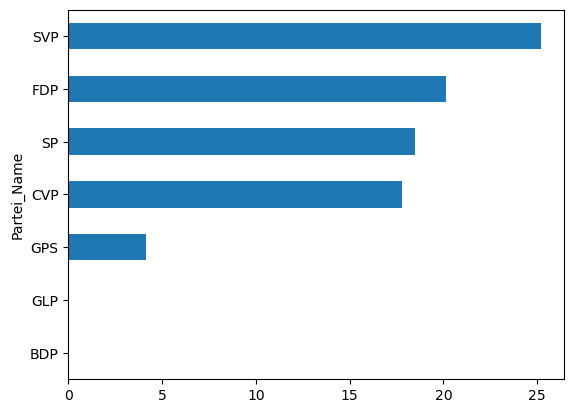

In [18]:
df.groupby('Partei_Name')['1999'].mean().sort_values().fillna(0).plot(kind='barh')

Und wie hoch waren die Wähleranteile der Parteien 2019 im Schnitt?

In [19]:
df.groupby('Partei_Name')['2019'].mean().sort_values()

Partei_Name
BDP     3.807922
GLP     6.616598
GPS    11.404856
CVP    12.836553
SP     13.792904
FDP    14.962460
SVP    31.178849
Name: 2019, dtype: float64

Machen wir nochmals einen Plot...

<AxesSubplot:ylabel='Partei_Name'>

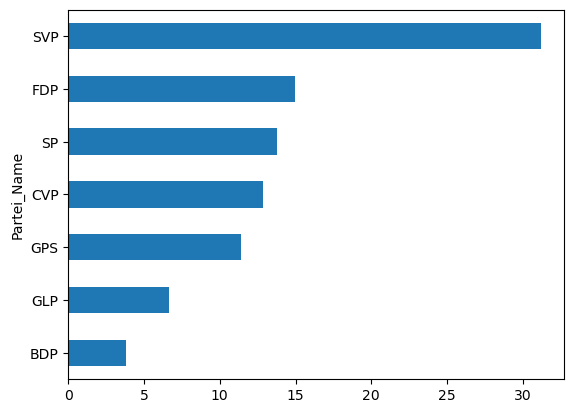

In [20]:
df.groupby('Partei_Name')['2019'].mean().sort_values().plot(kind='barh')

Wie viele Wählerprozente haben die Parteien im Schnitt zugelegt?

In [21]:
df.groupby('Partei_Name')['Differenz'].mean().sort_values()

Partei_Name
FDP   -5.151087
CVP   -4.976093
SP    -4.688600
BDP    3.807922
SVP    5.998782
GLP    6.616598
GPS    7.269837
Name: Differenz, dtype: float64

Plot:

<AxesSubplot:ylabel='Partei_Name'>

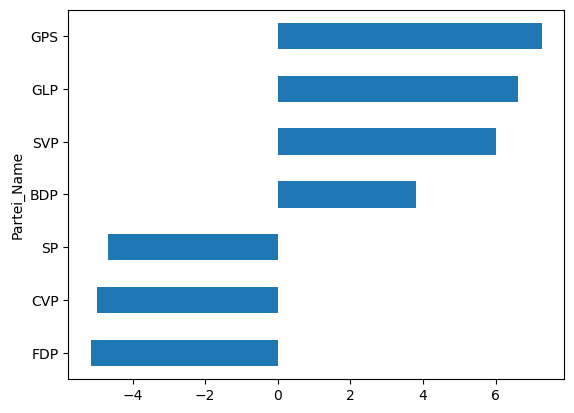

In [22]:
df.groupby('Partei_Name')['Differenz'].mean().sort_values().plot(kind='barh')

**Schöne Farben**

Übrigens... wir können für unsere Plots noch schönere Parteifarben hinzufügen.

Dazu definieren wir uns einen Dictionary von Parteien und dazugehörigen Farben:

In [23]:
colors = {
  "SVP": "#4B8A3E",
  "FDP": "#3872B5",
  "CVP": "#D6862B",
  "BDP": "#E6C820",
  "GLP": "#C4C43D",
  "SP": "#F0554D",
  "GPS": "#84B547"
}

So können wir zum Beispiel nach der Farbe der SVP fragen:

In [24]:
colors['SVP']

'#4B8A3E'

Pandas ist leider zu blöd, um diesen Dictionary einfach als Parameter für die Plotfunktion zu verstehen.

Daher müssen wir einen kleinen Trick anwenden.

Die Tabelle, die wir plotten wollen, speichern wir dazu kurz in einem Dataframe:

In [25]:
df_temp = df.groupby('Partei_Name')['Differenz'].mean().sort_values()
df_temp

Partei_Name
FDP   -5.151087
CVP   -4.976093
SP    -4.688600
BDP    3.807922
SVP    5.998782
GLP    6.616598
GPS    7.269837
Name: Differenz, dtype: float64

Für den Plot brauchen wir eine Liste von Farben, die entsprechend dieser Reihenfolge geordnet sind.

Wir machen das, in dem wir "list comprehension" verwenden. Das heisst: wie nehmen die Indexwerte der Tabelle (also die Parteien) und schlagen für jeden Eintrag die passende Farbet nach.

In [26]:
[colors[key] for key in df_temp.index]

['#3872B5', '#D6862B', '#F0554D', '#E6C820', '#4B8A3E', '#C4C43D', '#84B547']

<AxesSubplot:ylabel='Partei_Name'>

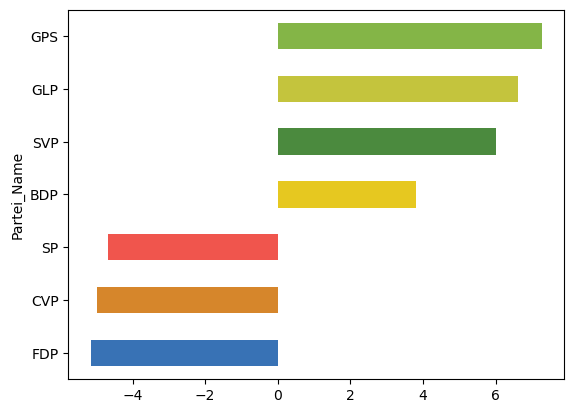

In [27]:
df_temp.plot(kind='barh', color=[colors[key] for key in df_temp.index])

## 2. Veränderung über Gruppen von Gemeinden hinweg

Nun kommen wir endlich zu dem Teil, der uns eigentlich interessiert: gruppierte Auswertungen!

Dazu müssen wir uns entscheiden:
- welche Partei wollen wir analysieren?
- welche Gemeindegruppierung interessiert uns?
- welchen Wählerwert wollen wir anschauen?

**Frage:** Was könnte eine mögliche Fragestellung sein?

In [28]:
# Hier Platz für Antwort

# zum Beispiel: Wie hat sich der Wähleranteil der SVP je nach räumlichem Gemeindetyp zwischen 1999 und 2019 verädnert

### a) anhand von qualitativen Merkmalen

Wir beginnen mal mit der Raumgliederung.

Und nehmen eine Partei in den Fokus...

In [29]:
partei = 'SVP'

... und filtern unseren Datensatz nach dieser Partei:

In [30]:
df_partei = df[df['Partei_Name'] == partei]

In [31]:
df_partei.head()

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019,Differenz
15,1,Aeugst am Albis,SVP,29.69,30.38,0.69
32,2,Affoltern am Albis,SVP,37.35,30.31,-7.04
49,3,Bonstetten,SVP,32.91,26.12,-6.79
66,4,Hausen am Albis,SVP,39.62,33.18,-6.44
83,5,Hedingen,SVP,34.75,26.60,-8.15


Jetzt folgt der entscheidende Schritt: die Gruppierung. Wir müssen zu jeder Gemeinde die Info hinzufügen, welchem Raumtyp sie angehört. (Remember, diese Infos sind im Hilfsdataframe hinterlegt, das wir geladen haben:

In [32]:
df_typen.head()

,Gemeinde_ID,Raumtyp,Grossregion,Sprache,Ausländeranteil,Bevölkerungswachstum_2010-17
0,1,3: Ländlich,4: Zürich,1: Deutsch,12.725399,6.414474
1,2,1: Städtisch,4: Zürich,1: Deutsch,28.593776,9.512217
2,3,2: Intermediär,4: Zürich,1: Deutsch,15.475327,6.842411
3,4,2: Intermediär,4: Zürich,1: Deutsch,15.147380,9.047619
4,5,1: Städtisch,4: Zürich,1: Deutsch,15.240931,8.328446


Um die zwei Tabellen zu "verbinden", können wir die Funktion `merge()` benutzen:
- Methode ("how"): nur die Gemeinden, die in beiden Tabellen vorkommen
- Datenfeld, das fürs matching verwendet wird ("on"): Gemeinde_ID

In [33]:
df_partei2 = df_partei.merge(df_typen, how='inner', on='Gemeinde_ID')

In [34]:
df_partei2.head()

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019,Differenz,Raumtyp,Grossregion,Sprache,Ausländeranteil,Bevölkerungswachstum_2010-17
0,1,Aeugst am Albis,SVP,29.69,30.38,0.69,3: Ländlich,4: Zürich,1: Deutsch,12.725399,6.414474
1,2,Affoltern am Albis,SVP,37.35,30.31,-7.04,1: Städtisch,4: Zürich,1: Deutsch,28.593776,9.512217
2,3,Bonstetten,SVP,32.91,26.12,-6.79,2: Intermediär,4: Zürich,1: Deutsch,15.475327,6.842411
3,4,Hausen am Albis,SVP,39.62,33.18,-6.44,2: Intermediär,4: Zürich,1: Deutsch,15.147380,9.047619
4,5,Hedingen,SVP,34.75,26.60,-8.15,1: Städtisch,4: Zürich,1: Deutsch,15.240931,8.328446


Jetzt haben wir ein Dataframe, das wir ganz einfach mit `groupby()` auswerten können.

In [35]:
df_partei2.groupby('Raumtyp')['Differenz'].mean()

Raumtyp
1: Städtisch      4.769729
2: Intermediär    5.021446
3: Ländlich       6.906893
Name: Differenz, dtype: float64

Für unseren Plot können wir die Farb-Zuordnung von vorher wieder benutzen! :-)

<AxesSubplot:title={'center':'Veränderung je nach Gemeinde-Raumtyp, SVP'}, ylabel='Raumtyp'>

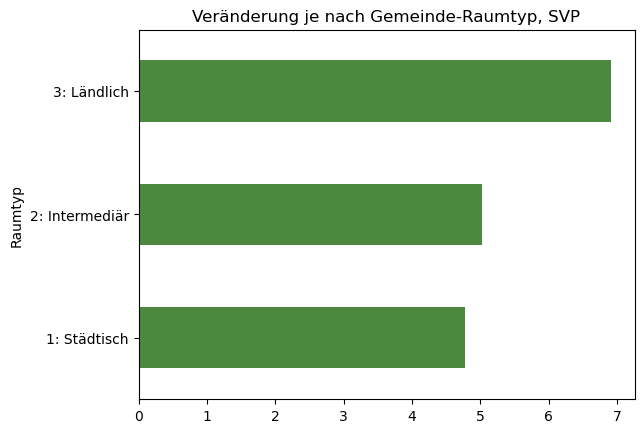

In [36]:
df_partei2.groupby('Raumtyp')['Differenz'].mean().plot(
    kind='barh', 
    color=colors[partei],
    title=('Veränderung je nach Gemeinde-Raumtyp, ' + partei))

### Übungsfragen

**Quiz:** Wie hoch waren 1999 die Wähleranteile der SP je nach Grossregion? Und 2019?

Lösungsweg:
- Datensatz nach der Partei filtern
- Gemeinde-Informationen hinzufügen
- Datensatz nach Gemeindegruppe auswerten

Erstellen Sie einen Plot und beschriften Sie ihn.

In [37]:
partei = 'FDP'

In [38]:
df_partei = df[df['Partei_Name'] == partei]

In [39]:
df_partei2 = df_partei.merge(df_typen, how='inner', on='Gemeinde_ID')

<AxesSubplot:title={'center':'Wähleranteil 1999 je nach Grossregion, FDP'}, ylabel='Grossregion'>

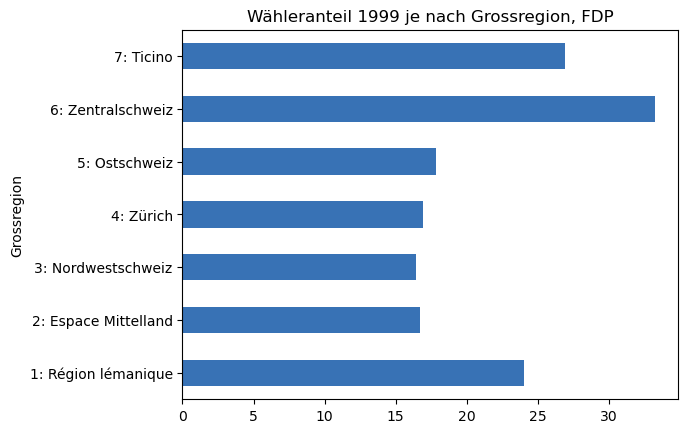

In [40]:
df_partei2.groupby('Grossregion')['1999'].mean().plot(
    kind='barh', 
    color=colors[partei],
    title=('Wähleranteil 1999 je nach Grossregion, ' + partei))

<AxesSubplot:title={'center':'Wähleranteil 2019 je nach Grossregion, FDP'}, ylabel='Grossregion'>

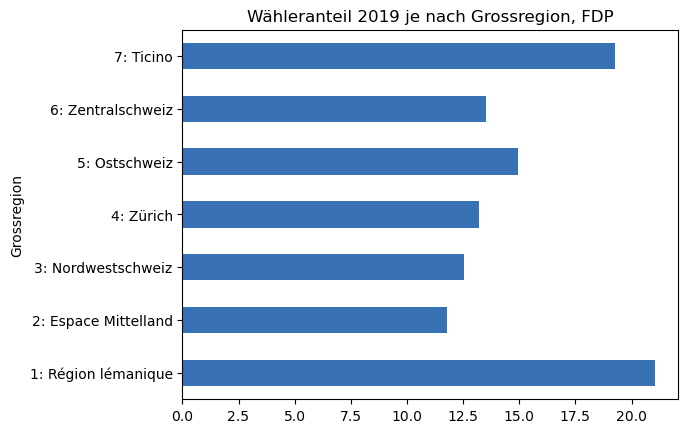

In [41]:
df_partei2.groupby('Grossregion')['2019'].mean().plot(
    kind='barh', 
    color=colors[partei],
    title=('Wähleranteil 2019 je nach Grossregion, ' + partei))

**Quiz:** Wie haben sich die Wähleranteile der CVP je nach Sprachregion verändert?

In [42]:
partei = 'CVP'

In [43]:
df_partei = df[df['Partei_Name'] == partei]

In [44]:
df_partei2 = df_partei.merge(df_typen, how='inner', on='Gemeinde_ID')

<AxesSubplot:title={'center':'Veränderung der Wähleranteile, CVP'}, ylabel='Sprache'>

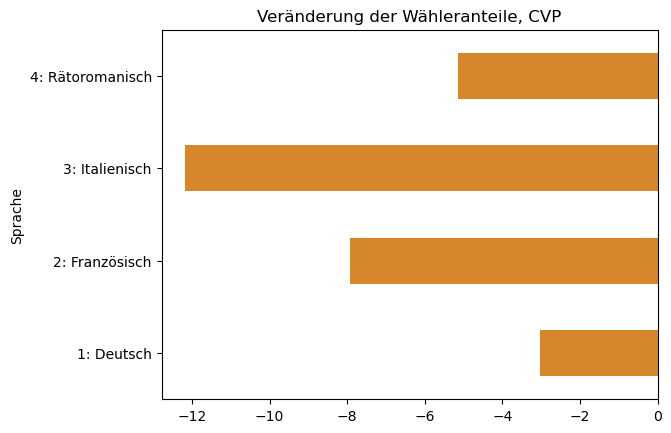

In [45]:
df_partei2.groupby('Sprache')['Differenz'].mean().plot(
    kind='barh', 
    color=colors[partei],
    title=('Veränderung der Wähleranteile, ' + partei))

**Quiz:** Wie hat sich der Wähleranteil der Grünen je nach Ausländerantei einer Gemeinde verändert?

In [46]:
# Hier stossen wir mit unserer bisherigen Methodik an die Grenzen.

### b) anhand von quantitativen Merkmalen

Der Ausländeranteil ist eine kontinuierliche Grössenangabe - es gibt hier noch keine Kategorien!

In [47]:
partei = 'GPS'

In [48]:
df_partei = df[df['Partei_Name'] == partei]

In [49]:
df_partei2 = df_partei.merge(df_typen, how='inner', on='Gemeinde_ID')

<AxesSubplot:xlabel='Ausländeranteil', ylabel='Differenz'>

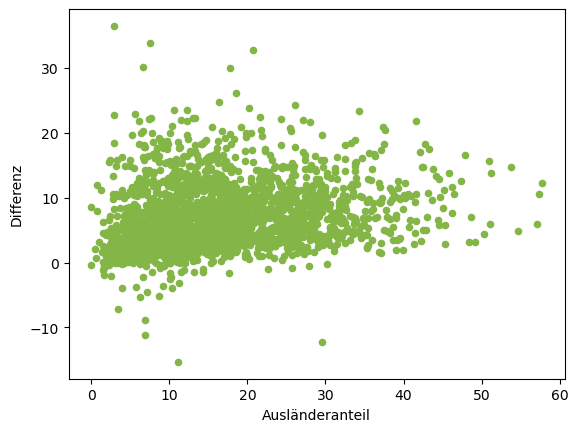

In [50]:
df_partei2.plot(kind='scatter', x='Ausländeranteil', y='Differenz', color=colors[partei])

Wir müssen zuerst unsere Kategorien basteln!

Dazu müssen wir zuerst mal wissen:
- anhand von welchen Grenzen wollen wir die Kategorien bilden? (z.B. 0-10%, 10-15%, etc.)
- wie wollen wir diese Kategorien beschriften?

Wir schauen erstmal, wie die Werte ungefähr verteilt sind.

<AxesSubplot:>

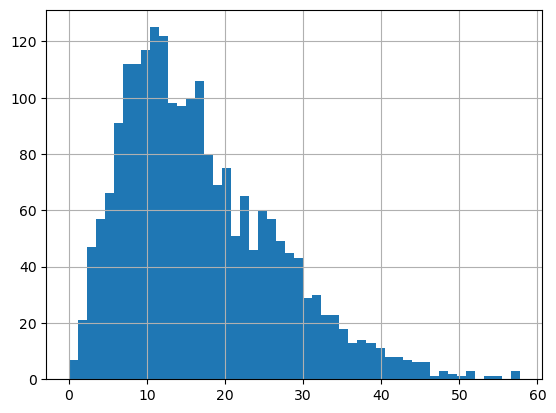

In [51]:
df_partei2['Ausländeranteil'].hist(bins=50)

Als nächstes erstellen wir zwei Listen (Achtung: es sind 6 Eckwerte aber nur 5 Labels):

In [52]:
bin_values = [
    0,
    10,
    15,
    20,
    25,
    np.inf
]

In [53]:
bin_codes = [
    "10 Prozent oder weniger",
    "10 bis 15 Prozent",
    "15 bis 20 Prozent",
    "20 bis 25 Prozent",
    "25 Prozent oder mehr"
]

Es gibt in Pandas eine praktische Funktion, mit der man die Kategorisierung vornehmen kann: `pd.cut()`

In [54]:
pd.cut(df_partei2['Ausländeranteil'], bin_values, labels=bin_codes, include_lowest=True)

0             10 bis 15 Prozent
1          25 Prozent oder mehr
2             15 bis 20 Prozent
3             15 bis 20 Prozent
4             15 bis 20 Prozent
                 ...           
2137    10 Prozent oder weniger
2138    10 Prozent oder weniger
2139    10 Prozent oder weniger
2140    10 Prozent oder weniger
2141    10 Prozent oder weniger
Name: Ausländeranteil, Length: 2142, dtype: category
Categories (5, object): ['10 Prozent oder weniger' < '10 bis 15 Prozent' < '15 bis 20 Prozent' < '20 bis 25 Prozent' < '25 Prozent oder mehr']

Jetzt speichern wir diese Kategorien einfach in einer neuen Spalte:

In [55]:
df_partei2['Ausländeranteil_Kat'] = pd.cut(df_partei2['Ausländeranteil'], bin_values, labels=bin_codes, include_lowest=True).astype(str)

In [56]:
df_partei2

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019,Differenz,Raumtyp,Grossregion,Sprache,Ausländeranteil,Bevölkerungswachstum_2010-17,Ausländeranteil_Kat
0,1,Aeugst am Albis,GPS,4.11,15.05,10.94,3: Ländlich,4: Zürich,1: Deutsch,12.725399,6.414474,10 bis 15 Prozent
1,2,Affoltern am Albis,GPS,3.02,12.59,9.57,1: Städtisch,4: Zürich,1: Deutsch,28.593776,9.512217,25 Prozent oder mehr
2,3,Bonstetten,GPS,5.35,12.37,7.02,2: Intermediär,4: Zürich,1: Deutsch,15.475327,6.842411,15 bis 20 Prozent
3,4,Hausen am Albis,GPS,3.63,16.74,13.11,2: Intermediär,4: Zürich,1: Deutsch,15.147380,9.047619,15 bis 20 Prozent
4,5,Hedingen,GPS,5.03,12.35,7.32,1: Städtisch,4: Zürich,1: Deutsch,15.240931,8.328446,15 bis 20 Prozent
...,...,...,...,...,...,...,...,...,...,...,...,...
2137,6806,Vendlincourt,GPS,0.00,9.30,9.30,3: Ländlich,2: Espace Mittelland,2: Französisch,9.335727,1.457195,10 Prozent oder weniger
2138,6807,Basse-Allaine,GPS,0.00,7.01,7.01,3: Ländlich,2: Espace Mittelland,2: Französisch,7.508251,-7.268554,10 Prozent oder weniger
2139,6808,Clos du Doubs,GPS,0.00,16.12,16.12,3: Ländlich,2: Espace Mittelland,2: Französisch,8.135073,3.330690,10 Prozent oder weniger
2140,6809,Haute-Ajoie,GPS,0.00,11.45,11.45,3: Ländlich,2: Espace Mittelland,2: Französisch,8.423913,-4.415584,10 Prozent oder weniger


Nun können wir unsere Auswertung wie zuvor vornehmen:

In [57]:
df_partei2.groupby('Ausländeranteil_Kat')['Differenz'].mean()

Ausländeranteil_Kat
10 Prozent oder weniger    5.767925
10 bis 15 Prozent          7.199448
15 bis 20 Prozent          7.706945
20 bis 25 Prozent          7.852944
25 Prozent oder mehr       8.351617
Name: Differenz, dtype: float64

<AxesSubplot:title={'center':'Veränderung je nach Ausländeranteil, GPS'}, ylabel='Ausländeranteil_Kat'>

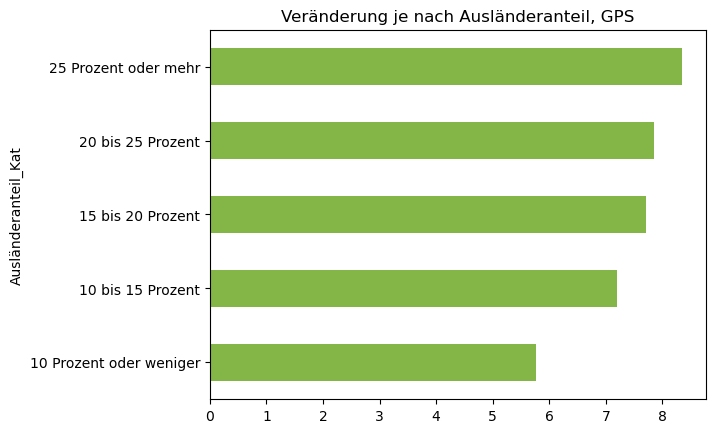

In [58]:
df_partei2.groupby('Ausländeranteil_Kat')['Differenz'].mean().plot(
    kind='barh',
    color=colors[partei],
    title=('Veränderung je nach Ausländeranteil, ' + partei))

### Übungsfragen

**Quiz:** Wie hat sich der Wähleranteil der CVP in schnell, wie in langsam wachsenden Gemeinden entwickelt?

Lösungsweg:
- Datensatz nach der Partei filtern
- Kategorisierung fürs Bevölkerungswachstum erstellen
- Gemeinde-Informationen hinzufügen
- Datensatz nach Gemeindegruppe auswerten

Erstellen Sie einen Plot und beschriften Sie ihn.

In [59]:
partei = 'CVP'

In [60]:
df_partei = df[df['Partei_Name'] == partei]

In [61]:
df_partei2 = df_partei.merge(df_typen, how='inner', on='Gemeinde_ID')

<AxesSubplot:>

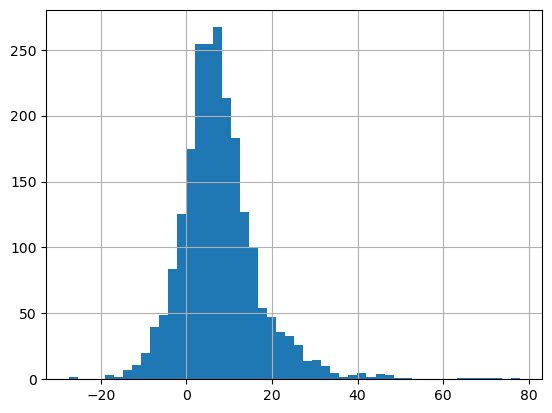

In [62]:
df_partei2['Bevölkerungswachstum_2010-17'].hist(bins=50)

In [63]:
bin_values = [
    -40,
    0,
    5,
    10,
    15,
    20,
    np.inf
]

In [64]:
bin_codes = [
    "1. unter 0 Prozent",
    "2. 0 bis 5 Prozent",
    "3. 5 bis 10 Prozent",
    "4. 10 bis 15 Prozent",
    "5. 15 bis 20 Prozent",
    "6. 20 Prozent oder mehr"
]

In [65]:
df_partei2['Bevölkerungswachstum_2010-17_Kat'] = pd.cut(df_partei2['Bevölkerungswachstum_2010-17'], bin_values, labels=bin_codes, include_lowest=True).astype(str)

In [66]:
df_partei2.groupby('Bevölkerungswachstum_2010-17_Kat')['Differenz'].mean()

Bevölkerungswachstum_2010-17_Kat
1. unter 0 Prozent        -4.934818
2. 0 bis 5 Prozent        -3.180897
3. 5 bis 10 Prozent       -4.905649
4. 10 bis 15 Prozent      -5.421105
5. 15 bis 20 Prozent      -7.124524
6. 20 Prozent oder mehr   -8.033591
Name: Differenz, dtype: float64

<AxesSubplot:title={'center':'Veränderung je nach Bevölkerungswachstum, CVP'}, ylabel='Bevölkerungswachstum_2010-17_Kat'>

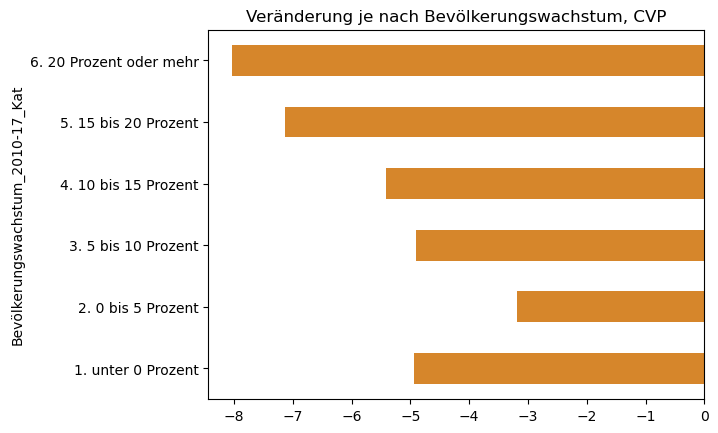

In [67]:
df_partei2.groupby('Bevölkerungswachstum_2010-17_Kat')['Differenz'].mean().plot(
    kind='barh',
    color=colors[partei],
    title=('Veränderung je nach Bevölkerungswachstum, ' + partei))

### 3. Räumliche Darstellung der Auswertungen

Es wäre nett, wenn wir die Veränderungen nicht nur als Balkenchart, sondern auch gleich auf einer Karte einzeichnen könnten!

Es gibt mehrere Wege, wie man da hinkommt.

### a) mit Geopandas

Wenn wir in unserer Jupyter-Notebook-Umgebung bleiben wollen, können wir Geopandas nutzen.

Wie das genau funktioniert, besprechen wir später noch ausführlich. Hier aber schonmal ein Beispiel.

**Shapefile laden**

Um etwas auf einer Karte einzeichen zu können, brauchen wir... eine Karte!

In der GIS-Welt heissen solche Karten "Shapefiles". Wir haben eines für die Schweizer Gemeinden zur Verfügung:

In [68]:
gdf = gpd.read_file('dataprojects/wahlen/shp/bfs-2019-wahl-gemeinden.shp')

Wir laden das Shapefile in ein so genanntes Geodataframe:

In [69]:
gdf

,id,name,geometry
0,1,Aeugst am Albis,"POLYGON ((678218.177 235219.160, 678559.177 23..."
1,10,Obfelden,"POLYGON ((673858.200 233032.123, 673589.198 23..."
2,100,Stadel,"POLYGON ((677038.969 263227.024, 676400.957 26..."
3,1001,Doppleschwand,"POLYGON ((647221.401 205116.054, 645315.931 20..."
4,1002,Entlebuch,"POLYGON ((647221.401 205116.054, 647504.397 20..."
...,...,...,...
2201,991,Walliswil bei Wangen,"POLYGON ((617584.596 230294.740, 617903.591 23..."
2202,992,Wangen an der Aare,"POLYGON ((615271.613 230125.714, 615148.615 23..."
2203,993,Wangenried,"POLYGON ((615271.613 230125.714, 616103.609 23..."
2204,995,Wiedlisbach,"POLYGON ((614314.580 234111.713, 614969.573 23..."


<AxesSubplot:>

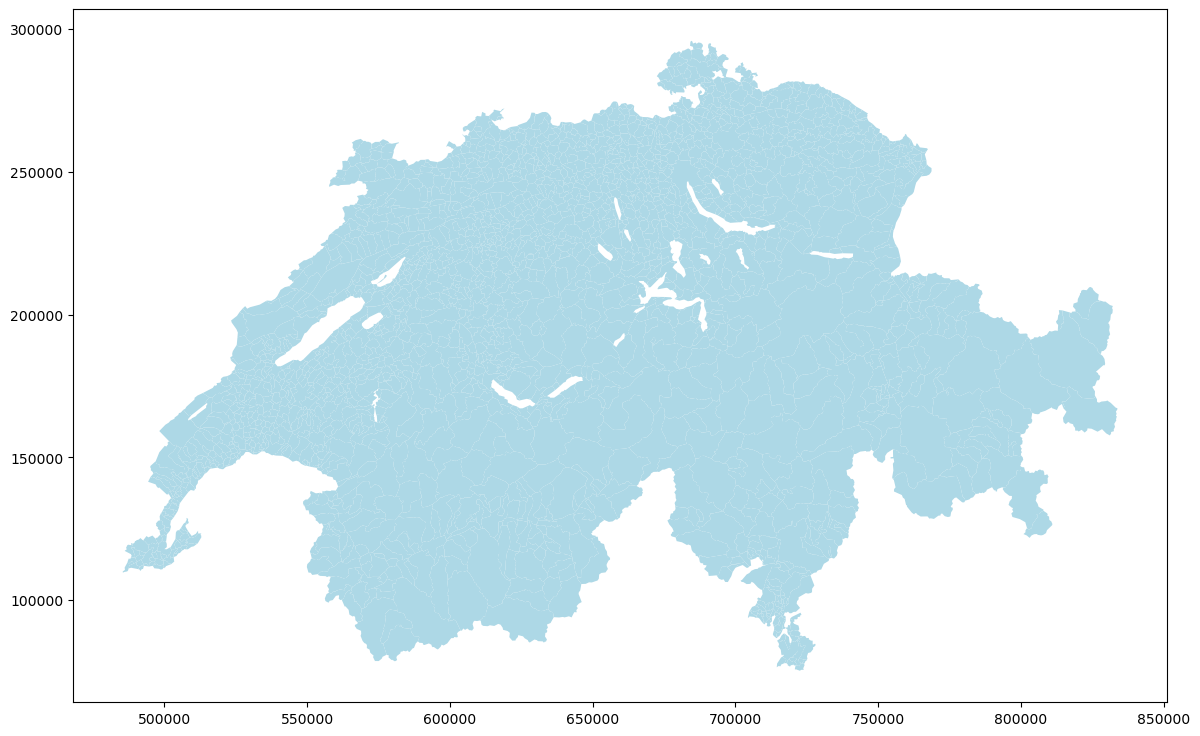

In [70]:
gdf.plot(color='lightblue', figsize=(15,9))

**Daten mit Shapefile verbinden**

Damit wir auf der Karte etwas einzeichnen können, müssen wir zu jeder Gemeinde eine Information hinzufügen.

Wir nehmen dazu unsere gewohnte Auswertung. Diesmal: Wie hoch ist der Wähleranteil der Grünen 2019?

In [71]:
partei = 'GPS'

In [72]:
df_partei = df[df['Partei_Name'] == partei]

In [73]:
df_partei.head()

,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019,Differenz
9,1,Aeugst am Albis,GPS,4.11,15.05,10.94
26,2,Affoltern am Albis,GPS,3.02,12.59,9.57
43,3,Bonstetten,GPS,5.35,12.37,7.02
60,4,Hausen am Albis,GPS,3.63,16.74,13.11
77,5,Hedingen,GPS,5.03,12.35,7.32


... und matchen sie mit `merge()` ins Geodatenframe:

In [74]:
gdf_partei = gdf.merge(df_partei, how='inner', left_on='id', right_on='Gemeinde_ID')

In [75]:
gdf_partei.head()

,id,name,geometry,Gemeinde_ID,Gemeinde_Name,Partei_Name,1999,2019,Differenz
0,1,Aeugst am Albis,"POLYGON ((678218.177 235219.160, 678559.177 23...",1,Aeugst am Albis,GPS,4.11,15.05,10.94
1,10,Obfelden,"POLYGON ((673858.200 233032.123, 673589.198 23...",10,Obfelden,GPS,3.28,8.55,5.27
2,100,Stadel,"POLYGON ((677038.969 263227.024, 676400.957 26...",100,Stadel,GPS,5.39,10.19,4.80
3,1001,Doppleschwand,"POLYGON ((647221.401 205116.054, 645315.931 20...",1001,Doppleschwand,GPS,0.84,1.52,0.68
4,1002,Entlebuch,"POLYGON ((647221.401 205116.054, 647504.397 20...",1002,Entlebuch,GPS,2.18,3.60,1.42


**Plotten**

Geopandas hat eine Plot-Funktion, die ähnlich funktioniert wie in Pandas.

Wichtig: wir müssen angeben, anhand von welcher Information die Farbgebung erstellt werden soll!

Text(0.5, 1.0, 'Wähleranteil 2019 in Prozentpunkten GPS')

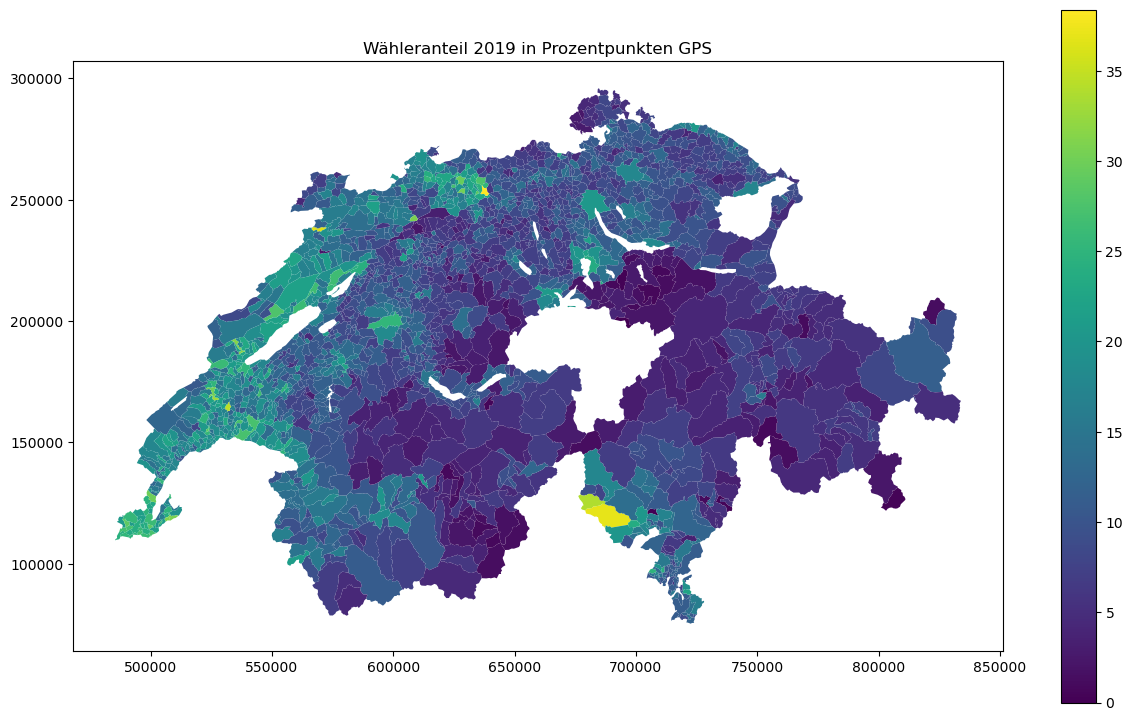

In [76]:
# Plot
ax = gdf_partei.plot(column='2019', legend=True, figsize=(15,9))

ax.set_title("Wähleranteil 2019 in Prozentpunkten " + partei)

Standardmässig werden die Daten anhand einer kontinuierlichen Skala dargestellt.

Wir können diese Skala auch austauschen. Eine Auswahl von Skalen gibt es hier:

https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html

Wichtig auch: Die Min/Max-Werte einstellen.

Text(0.5, 1.0, 'Wähleranteil 2019 in Prozentpunkten GPS')

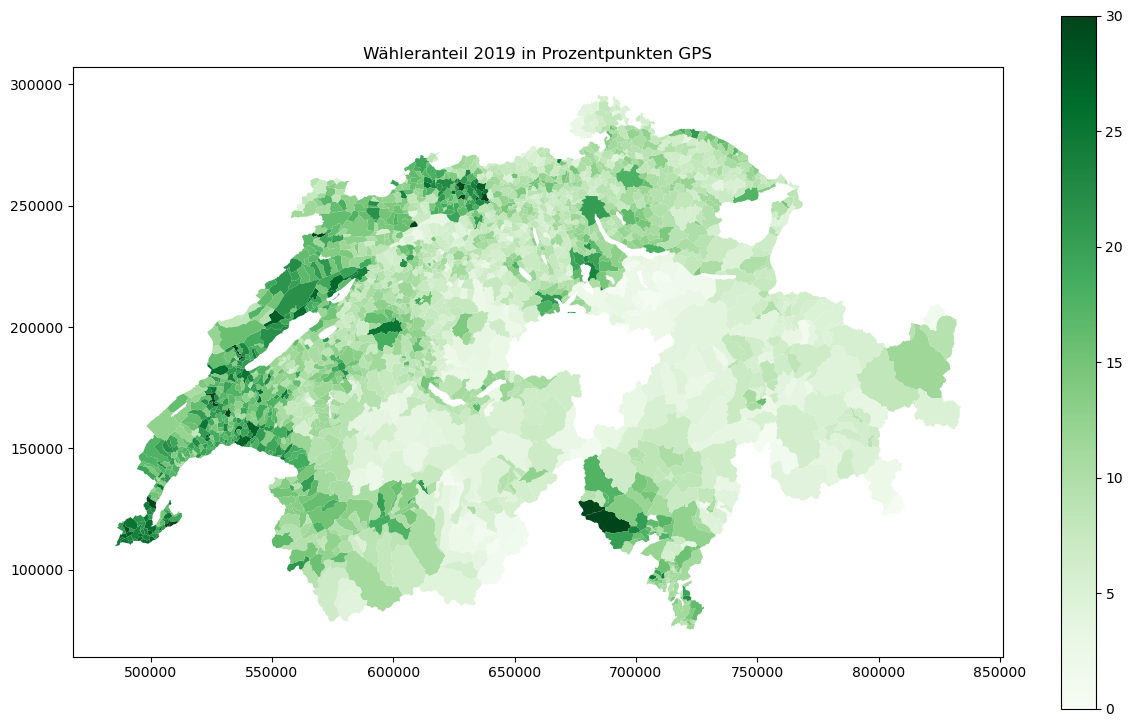

In [77]:
# Plot
ax = gdf_partei.plot(
    column='2019',
    cmap='Greens',
    vmin=0,
    vmax=30,
    figsize=(15,9),
    legend=True)

ax.set_title("Wähleranteil 2019 in Prozentpunkten " + partei)

Das Herumspielen mit Minimal- und Maximalwerten lohnt sich. Es kommt drauf an, was man hervorheben will!

Wir können uns auch eigene Grenzwerte erstellen:

In [78]:
bins = [
    0, 5, 10, 15, 20, 25
]

Text(0.5, 1.0, 'Wähleranteil 2019 in Prozentpunkten GPS')

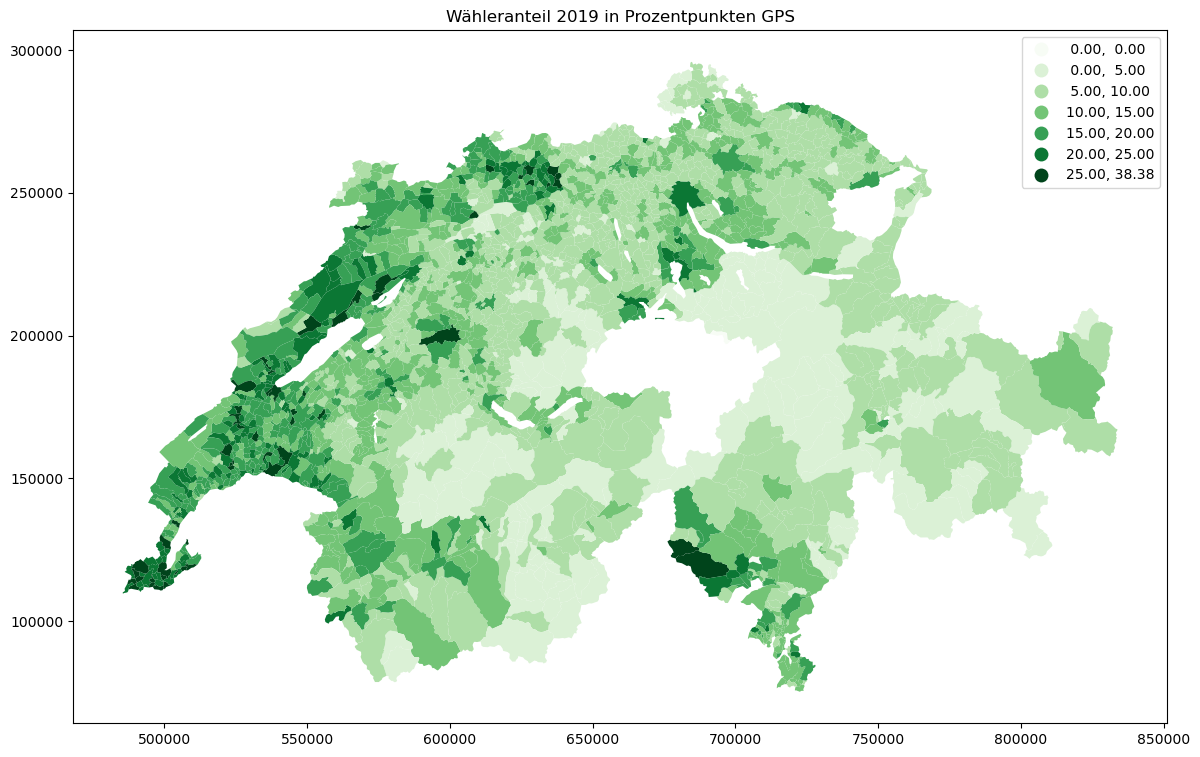

In [79]:
# Plot
ax = gdf_partei.plot(
    column='2019',
    cmap='Greens',
    scheme='user_defined',
    classification_kwds={'bins': bins},
    figsize=(15,9),
    legend=True)

ax.set_title("Wähleranteil 2019 in Prozentpunkten " + partei)

### b) mit einem externen Tool

zum Beispiel: Datawrapper. https://www.datawrapper.de/

Dort hat es diverse Maps bereits vorprogrammiert - auch die Schweizer Gemeinden.

Um es zu benutzen, müssen wir die Daten exportieren:

In [80]:
party = 'GPS'

In [81]:
year = '2019'

In [82]:
df_temp = df[df['Partei_Name'] == party][['Gemeinde_ID', 'Gemeinde_Name', year]]
df_temp.to_csv('dataprojects/wahlen/charts/' + party + '-' + year + '.csv', index=False)